In [1]:
#Ï†ÑÏ≤òÎ¶¨ ÏΩîÎìú ÌôïÏù∏ ÌïÑÏöî X
import pandas as pd
import numpy as np

df11=pd.read_csv('C:\\Users\\Ïû•Ïû¨ÏöîÏõêÏßÄ\\Downloads\\merged_dataset_post_with_images_with_captions.csv',encoding='utf-8-sig')
df=df11
#df = pd.read_csv('C:\\Users\\Ïû•Ïû¨ÏöîÏõêÏßÄ\\Downloads\\merged_dataset_post_with_images_with_captions.csv', encoding='utf-8')

def count_hashtags(x):
    if pd.isna(x):
        return 0
    # Îπà Î¨∏ÏûêÏó¥ Ï≤òÎ¶¨
    x = x.strip()
    if not x:
        return 0
    return len([tag for tag in x.split(',') if tag.strip()])

df['hashtag_count'] = df['hashtags'].apply(count_hashtags)
df['mention_count'] = df['mentions'].apply(count_hashtags)
df=df.drop(columns=['mentions','hashtags'])
df=df[df['caption'].isna()==False]

df_captionlen=df['caption'].apply(lambda x: len(x))
df['captionlen']=df_captionlen

from datetime import datetime

df["day_of_week"] = df["timestamp"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%A"))
df["hour"] = df["timestamp"].apply(lambda x: int(datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%H")))
df["day_of_year"] = df["timestamp"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%Y"))

In [2]:
#Ï†ÑÏ≤òÎ¶¨ ÏΩîÎìú ÌôïÏù∏ ÌïÑÏöî X 2

df2=df.drop(columns=['caption','timestamp','owner_fullName','owner_verified','owner_biography','isSponsored','images'])

df2['day_of_year']=df2['day_of_year'].astype(int)
df2 = pd.get_dummies(
    df2,
    columns=['day_of_week', 'owner_businessCategoryName'],
    dtype=int  # intÎ°ú ÏßÄÏ†ï
)
df2=df2[df2['owner_id'].isna()==False]

df2 = df2[df2['likesCount'] >= 0]
# owner_idÎ≥Ñ likesCount ÌèâÍ∑†
df2['owner_avg_likesCount'] = df2.groupby('owner_id')['likesCount'].transform('mean')

# owner_idÎ≥Ñ likesCount Ï§ëÏïôÍ∞í
df2['owner_median_likesCount'] = df2.groupby('owner_id')['likesCount'].transform('median')
df2['owner_median_commentCount'] = df2.groupby('owner_id')['commentsCount'].transform('median')
df2['owner_var_likesCount'] = df2.groupby('owner_id')['likesCount'].transform('var')
# ÌëúÏ§ÄÌé∏Ï∞® Ïª¨Îüº Ï∂îÍ∞Ä (Î£®Ìä∏ Î∂ÑÏÇ∞)
df2['owner_std_likesCount'] = np.sqrt(df2['owner_var_likesCount'])
df2['mean_impress']=df2['owner_avg_likesCount']/df2['owner_followersCount']
# ÏµúÏ¢Ö Ï¢ãÏïÑÏöî ÏòàÏ∏°ÌïòÍ∏∞
y = df2['likesCount'] # yÎäî likesCountÏôÄ commentsCount

x = df2.drop(columns=['owner_businessCategoryName_None,Health/beauty','mean_impress','owner_median_commentCount','owner_id','likesCount', 'commentsCount','impression'])  # ÎÇòÎ®∏ÏßÄ Ïó¥ÏùÄ x
#x = df2.drop(columns=['likesCount', 'impression'])  # ÎÇòÎ®∏ÏßÄ Ïó¥ÏùÄ x

# owner_followersCountÏùò Í∞Å Í∞íÏùò Í∞úÏàòÎ•º ÏÑ∏Í∏∞
counts = x['owner_followersCount'].value_counts()
print(counts)
x = x[x['owner_followersCount'].isin(counts[counts > 1].index)]
y = y[x.index]

owner_followersCount
2459253.0    144
1011338.0     88
189595.0      85
347415.0      81
562380.0      64
28214.0       61
236233.0      51
467836.0      50
334943.0      50
100081.0      45
559518.0      39
564283.0      33
255675.0      20
292326.0      13
72922.0       13
169886.0      12
550161.0      12
422331.0       8
13550.0        7
34772.0        6
127966.0       5
372155.0       3
25570.0        1
Name: count, dtype: int64


In [3]:
#Ï∫°ÏÖò ÏûÑÎ≤†Îî© Î™®Îç∏ Î°úÎìú 
from sentence_transformers import SentenceTransformer

# ÏµúÏ†ÅÌôîÎêú Î™®Îç∏ ÏÑ†ÌÉù (384Ï∞®Ïõê Ï∂úÎ†•)
model = SentenceTransformer('all-MiniLM-L6-v2')

C:\Users\Ïû•Ïû¨ÏöîÏõêÏßÄ\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# ÌÖçÏä§Ìä∏ Ï∂îÏ∂ú
texts = x['image_captions'].tolist()

# ÏûÑÎ≤†Îî© Î≥ÄÌôò (CPU Í∏∞Î≥∏ Ïã§Ìñâ)
embeddings = model.encode(texts, show_progress_bar=True)

# Í≤∞Í≥º ÌôïÏù∏
print(f"ÏûÖÎ†• ÌÖçÏä§Ìä∏ Ïàò: {len(texts)}")
print(f"Ï∂úÎ†• Ï∞®Ïõê: {embeddings.shape[1]}")  # 384 ÌôïÏù∏

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóê Ï†ÄÏû•
x['image_embeddings'] = embeddings.tolist()

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

ÏûÖÎ†• ÌÖçÏä§Ìä∏ Ïàò: 890
Ï∂úÎ†• Ï∞®Ïõê: 384


In [5]:

# ÏûÑÎ≤†Îî© Î∞∞Ïó¥ Î≥ÄÌôò
embeddings_array = np.vstack(x['image_embeddings'].values)
print(f"ÏûÖÎ†• Ï∞®Ïõê: {embeddings_array.shape}")  # (890, 384)

ÏûÖÎ†• Ï∞®Ïõê: (890, 384)


In [6]:
#1Ï∞®Ïõê ÏïïÏ∂ï (Ïù¥ÎØ∏ÏßÄ Ï∫°ÏÖò)

import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

# Ïò§ÌÜ†Ïù∏ÏΩîÎçî Î™®Îç∏ Ï†ïÏùò (Îã®ÏàúÌôî Î≤ÑÏ†Ñ)
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)  # 1Ï∞®Ïõê ÏïïÏ∂ï
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(384)  # ÏõêÎ≥∏ Ï∞®Ïõê Î≥µÏõê
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# ÌïôÏäµ Ïã§Ìñâ (5Î∂Ñ ÎÇ¥Ïô∏)
history = autoencoder.fit(embeddings_array, embeddings_array,
                         epochs=50, batch_size=32, verbose=1)

# ÏïïÏ∂ï Î∞è Î≥µÏõê
compressed = encoder.predict(embeddings_array)  # (890, 1)
reconstructed = autoencoder.predict(embeddings_array)  # (890, 384)

# ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
cos_sim = cosine_similarity(embeddings_array, reconstructed).diagonal()
print(f"ÌèâÍ∑† ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ: {np.mean(cos_sim):.4f}")

# Í≤∞Í≥º Ï†ÄÏû•
x['compressed_1d'] = compressed.tolist()


Epoch 1/50

28/28 [==============================] - 3s 7ms/step - loss: 0.0023
Epoch 2/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 3/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 4/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 5/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 6/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 7/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 8/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 10/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 11/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 12/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 13/50
28/28 [============================

In [7]:
#x 1Ï∞®ÏõêÏïïÏ∂ïÏôÑÎ£å Î∞è object Ïª¨Îüº Ï†úÍ±∞

x['compressed_1d'] = x['compressed_1d'].apply(lambda val: val[0])
x.drop(columns=['image_captions','image_embeddings'],inplace=True)


owner_followersCount                                    float64
owner_postsCount                                        float64
hashtag_count                                             int64
mention_count                                             int64
captionlen                                                int64
hour                                                      int64
day_of_year                                               int32
day_of_week_Friday                                        int32
day_of_week_Monday                                        int32
day_of_week_Saturday                                      int32
day_of_week_Sunday                                        int32
day_of_week_Thursday                                      int32
day_of_week_Tuesday                                       int32
day_of_week_Wednesday                                     int32
owner_businessCategoryName_Actor                          int32
owner_businessCategoryName_Album        

In [46]:
#ÌïÑÏöîÌïú Ï†ïÎ≥¥-> ÌåîÎ°úÏõåÏàò, Ìï¥ÏãúÌÉúÍ∑∏ Í∞úÏàò, Î©òÏÖòÍ∞úÏàò, Ï∫°ÏÖòÍ∏∏Ïù¥, Ïò¨Î¶¨Îäî ÏãúÍ∞Ñ, ÏöîÏùº, Í≥ÑÏ†ïÏ¢ÖÎ•ò, Ïù¥ÎØ∏ÏßÄ Ï∫°ÏÖò

selected_features = ['owner_followersCount', 'hashtag_count',
       'mention_count', 'captionlen', 'hour', 'day_of_year',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'owner_businessCategoryName_Actor',
       'owner_businessCategoryName_Album', 'owner_businessCategoryName_Artist',
       'owner_businessCategoryName_Clothing (Brand)',
       'owner_businessCategoryName_Comedy club',
       'owner_businessCategoryName_Community',
       'owner_businessCategoryName_Digital creator',
       'owner_businessCategoryName_Model',
       'owner_businessCategoryName_Motivational speaker',
       'owner_businessCategoryName_Movie/television studio',
       'owner_businessCategoryName_None,Media',
       'owner_businessCategoryName_None,News & media website',
       'owner_businessCategoryName_None,Shopping & retail',
       'owner_businessCategoryName_None,Video creator',
       'owner_businessCategoryName_Scientist',
       'owner_businessCategoryName_Video creator',
        'compressed_1d']


In [74]:
len(selected_features)

30

In [36]:
x.columns

Index(['owner_followersCount', 'owner_postsCount', 'hashtag_count',
       'mention_count', 'captionlen', 'hour', 'day_of_year',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'owner_businessCategoryName_Actor',
       'owner_businessCategoryName_Album', 'owner_businessCategoryName_Artist',
       'owner_businessCategoryName_Clothing (Brand)',
       'owner_businessCategoryName_Comedy club',
       'owner_businessCategoryName_Community',
       'owner_businessCategoryName_Digital creator',
       'owner_businessCategoryName_Model',
       'owner_businessCategoryName_Motivational speaker',
       'owner_businessCategoryName_Movie/television studio',
       'owner_businessCategoryName_None,Media',
       'owner_businessCategoryName_None,News & media website',
       'owner_businessCategoryName_None,Shopping & retail',
       'owner_businessCategoryName_N

In [57]:
#ramdomforeast
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=102)

# ÏÑ†ÌÉùÎêú ÌîºÏ≤òÎ°ú Îç∞Ïù¥ÌÑ∞ ÏÑ†ÌÉù
x_train_sel1 = x_train.loc[:, selected_features]
x_test_sel1 = x_test.loc[:, selected_features]

# MinMax Ïä§ÏºÄÏùºÎßÅ
scaler = MinMaxScaler()
x_train_sel = scaler.fit_transform(x_train_sel1)
x_test_sel = scaler.transform(x_test_sel1)


x_t = x_test

# ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ Î™®Îç∏ Ï†ïÏùò Î∞è ÌïôÏäµ

#model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
#ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù Í≤∞Í≥º
model = RandomForestRegressor(
    n_estimators=112,
    max_depth=13,
    min_samples_split=9,
    min_samples_leaf=3,
    max_features=None,
    random_state=42,
    n_jobs=-1
)


# ÏÑ†ÌÉùÎêú ÌîºÏ≤òÎ°ú ÌïôÏäµ
model.fit(x_train_sel, y_train)

# ÏòàÏ∏°
y_pred = model.predict(x_test_sel)

# sMAPE Ìï®Ïàò Ï†ïÏùò
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator[denominator == 0] = 1e-8  # 0ÏúºÎ°ú ÎÇòÎàÑÎäî Í≤É Î∞©ÏßÄ
    return np.mean(np.abs(y_pred - y_true) / denominator) * 100


# ÌèâÍ∞Ä - ÌîºÏ≤òÏÖÄÎ†â ÌñàÏùÑ Îïå
print("ÌîºÏ≥êÏÖÄÎ†â ÌñáÏùÑÎïå")
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.8f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R¬≤ Score: {r2:.2f}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"mean_absolute_percentage_erro: {mape:.2f}")

owner_std = np.sqrt(x_t['owner_var_likesCount'].values)  # ÌëúÏ§ÄÌé∏Ï∞®Î°ú Î≥ÄÌôò
owner_std[owner_std == 0] = 1
nmae = np.mean(np.abs(y_test - y_pred) / owner_std)
print(f"Normalized MAE (by user group std): {nmae:.5f}")

smape_val = smape(y_test.values, y_pred)
print(f"sMAPE: {smape_val:.2f}%")


ÌîºÏ≥êÏÖÄÎ†â ÌñáÏùÑÎïå
Mean Squared Error: 582364484.40184796
Mean Absolute Error: 12893.29552
R¬≤ Score: 0.72
mean_absolute_percentage_erro: 0.68
Normalized MAE (by user group std): 0.63548
sMAPE: 42.66%


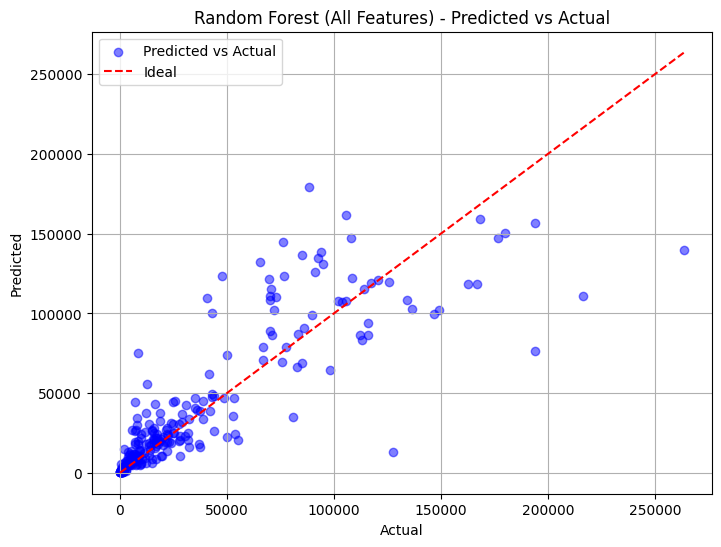

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest (All Features) - Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Ïú†Ï†ÄÎç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [79]:
user_input = {
    "owner_followersCount": 500001,            # ÌåîÎ°úÏõå Ïàò
    "hashtags": ['travel', 'sunset'],                  # Ïòà: ['travel', 'sunset']
    "mentions": ['@friend1', '@brand'],                  # Ïòà: ['@friend1', '@brand']
    "caption": 'i like play football',                         # Ïù∏Ïä§ÌÉÄ ÌÖçÏä§Ìä∏ ÏÑ§Î™Ö
    "timestamp": '2025-06-05 14:30:00',                       # '2025-06-05 14:30:00' ÌòïÏãù
    "owner_businessCategoryName": 'Digital creator',      # Ïòà: 'Digital creator'
    "image_caption": 'the man play football with father'                    # Ïù¥ÎØ∏ÏßÄ Ï∫°ÏÖò Î¨∏Ïû•
}

In [80]:
hashtag_count = len(user_input['hashtags'])
mention_count = len(user_input['mentions'])
captionlen = len(user_input['caption']) if pd.notna(user_input['caption']) else 0


In [81]:
timestamp = pd.to_datetime(user_input['timestamp'])
hour = timestamp.hour
day_of_year = timestamp.dayofyear
day_of_week = timestamp.day_name()  # Ïòà: 'Friday'


In [82]:
# day_of_week Ïõê-Ìï´ Î≤°ÌÑ∞
dow_features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
day_of_week_onehot = {f'day_of_week_{d}': int(day_of_week == d) for d in dow_features}

# business category Ïõê-Ìï´ Î≤°ÌÑ∞
bc_features = [
    'Actor', 'Album', 'Artist', 'Clothing (Brand)', 'Comedy club', 'Community',
    'Digital creator', 'Model', 'Motivational speaker', 'Movie/television studio',
    'None,Media', 'None,News & media website', 'None,Shopping & retail',
    'None,Video creator', 'Scientist', 'Video creator'
]
businessCategory = user_input['owner_businessCategoryName']
bc_onehot = {f'owner_businessCategoryName_{b}': int(businessCategory == b) for b in bc_features}


In [83]:
# sentence embedding
from sentence_transformers import SentenceTransformer
import numpy as np

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
caption_embedding = embedding_model.encode([user_input['image_caption']])  # shape: (1, 384)

# autoencoder encoder Î™®Îç∏ÏùÑ ÌÜµÌï¥ ÏïïÏ∂ïÎêú 1Ï∞®Ïõê ÏûÑÎ≤†Îî© Ï∂îÏ∂ú
caption_embedding_tf = tf.convert_to_tensor(caption_embedding, dtype=tf.float32)
compressed_1d = encoder.predict(caption_embedding_tf)[0][0]

2025-06-06 00:45:59,587 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-06-06 00:45:59,601 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
C:\Users\Ïû•Ïû¨ÏöîÏõêÏßÄ\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


In [84]:
final_input_dict = {
    "owner_followersCount": user_input['owner_followersCount'],
    "hashtag_count": hashtag_count,
    "mention_count": mention_count,
    "captionlen": captionlen,
    "hour": hour,
    "day_of_year": day_of_year,
    **day_of_week_onehot,
    **bc_onehot,
    "compressed_1d": compressed_1d
}

In [85]:
final_input_dict

{'owner_followersCount': 500001,
 'hashtag_count': 2,
 'mention_count': 2,
 'captionlen': 20,
 'hour': 14,
 'day_of_year': 156,
 'day_of_week_Friday': 0,
 'day_of_week_Monday': 0,
 'day_of_week_Saturday': 0,
 'day_of_week_Sunday': 0,
 'day_of_week_Thursday': 1,
 'day_of_week_Tuesday': 0,
 'day_of_week_Wednesday': 0,
 'owner_businessCategoryName_Actor': 0,
 'owner_businessCategoryName_Album': 0,
 'owner_businessCategoryName_Artist': 0,
 'owner_businessCategoryName_Clothing (Brand)': 0,
 'owner_businessCategoryName_Comedy club': 0,
 'owner_businessCategoryName_Community': 0,
 'owner_businessCategoryName_Digital creator': 1,
 'owner_businessCategoryName_Model': 0,
 'owner_businessCategoryName_Motivational speaker': 0,
 'owner_businessCategoryName_Movie/television studio': 0,
 'owner_businessCategoryName_None,Media': 0,
 'owner_businessCategoryName_None,News & media website': 0,
 'owner_businessCategoryName_None,Shopping & retail': 0,
 'owner_businessCategoryName_None,Video creator': 0,
 '

In [86]:
import pandas as pd

# 1ÌñâÏßúÎ¶¨ DataFrame ÏÉùÏÑ±
input_df = pd.DataFrame([final_input_dict])

# Î™®Îç∏Ïù¥ Í∏∞ÎåÄÌïòÎäî Ïª¨Îüº ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨
input_df = input_df[selected_features]


In [92]:
y_pred_user = model.predict(input_df)  # Î™®Îç∏ ÏòàÏ∏° (ÌöåÍ∑ÄÍ∞í)
print(y_pred_user[0])


C:\Users\Ïû•Ïû¨ÏöîÏõêÏßÄ\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


138493.84693849058


In [ ]:
###########Î∞ëÏóêÎäî RAG langchain

In [88]:
import os
import langchain
import faiss
import PyPDF2
# ÌôòÍ≤Ω Î≥ÄÏàòÎ°ú API ÌÇ§ ÏÑ§Ï†ï
os.environ["GOOGLE_API_KEY"] = ""
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini 1.5 Flash Î™®Îç∏Î°ú ÏÑ§Ï†ï
llm = ChatGoogleGenerativeAI(
    model="models/gemini-1.5-flash-latest",  # ‚Üê Ïù¥ Î∂ÄÎ∂ÑÎßå Î≥ÄÍ≤Ω!
    temperature=0.7
)

2025-06-06 01:11:54,903 - faiss.loader - INFO - Loading faiss with AVX2 support.
2025-06-06 01:11:56,543 - faiss.loader - INFO - Successfully loaded faiss with AVX2 support.
2025-06-06 01:11:56,695 - faiss - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.


In [ ]:
#'C:\\Users\\Ïû•Ïû¨ÏöîÏõêÏßÄ\\Downloads\\merged_dataset_post_with_images_with_captions.csv'

In [89]:
from langchain_community.document_loaders import PyPDFLoader

file_path = r'insta_context.pdf'

loader = PyPDFLoader(file_path)
docs = loader.load()

# Ï†ÑÏ≤¥ ÌéòÏù¥ÏßÄ Ïàò ÌôïÏù∏
print(f"Ï¥ù ÌéòÏù¥ÏßÄ Ïàò: {len(docs)}")

# Í∞Å ÌéòÏù¥ÏßÄÎ≥Ñ ÎÇ¥Ïö© ÎØ∏Î¶¨Î≥¥Í∏∞
for i, doc in enumerate(docs):
    print(f"\n--- Page {i+1} ---")
    print(doc.page_content[:500]) 

Ï¥ù ÌéòÏù¥ÏßÄ Ïàò: 162

--- Page 1 ---
THE ULTIMATE GUIDE TO 
INSTAGRAM MARKETING
Whether you‚Äôre B2B or B2C, there‚Äôs a path 
to Instagram success.

--- Page 2 ---
LET‚ÄôS GET STARTED
If your brand‚Äôs not on Instagram, it should be. And if it already is, there‚Äôs 
always room for improvement. Let‚Äôs start with the stats: 
‚Ä¢ Today, there are 500 million monthly active Instagram users 
‚Ä¢ 95 million photos and videos are shared every day 
‚Ä¢ Photos earn 4.2 billion likes per day 
‚Ä¢ Research Ô¨Årm L2 found that Instagram had the highest conversion rate ‚Äì 
more than 15 times that of Facebook 
‚Ä¢ The average engagement rate on Instagram is 2.26% vs Facebook‚Äôs 0.21% 
and 

--- Page 3 ---
HOW TO SET, MEASURE AND TRACK YOUR 
INSTAGOALS
SET YOUR GOALS 
Before you embark on your Instagram journey, you need to start with one question: Why am I  
doing this? 
DeÔ¨Åning your ‚Äúwhy‚Äù helps you to set measurable targets to track your success. Every business 
has diÔ¨Äerent goals wh

In [100]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate


# 2. ÌÖçÏä§Ìä∏ Î∂ÑÌï†
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
split_docs = text_splitter.split_documents(docs)

# 3. ÏûÑÎ≤†Îî© Î™®Îç∏ ÏÑ§Ï†ï
embedding_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# 4. FAISS Î≤°ÌÑ∞ Ï†ÄÏû•ÏÜå ÏÉùÏÑ±
vectorstore = FAISS.from_documents(split_docs, embedding_model)

# 5. QA Ï≤¥Ïù∏ Íµ¨ÏÑ±
retriever = vectorstore.as_retriever()
llm = ChatGoogleGenerativeAI(model="models/gemini-1.5-flash", temperature=0)

# PromptTemplate ÏÑ§Ï†ï
custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
ÎÑàÎäî Ïù∏Ïä§ÌÉÄÍ∑∏Îû® Í≤åÏãúÎ¨º Ìù•Ìñâ Ï†ÑÎûµ Ïú†Î£å Î¶¨Ìè¨Ìä∏Î•º ÏßúÏ£ºÎäî ÌîÑÎ°úÍ∑∏Îû®Ïù¥Ïïº 
Ï¢ãÏïÑÏöî ÏàòÎ•º Îçî ÎÜíÏù¥Í∏∞ ÏúÑÌï¥ Ïñ¥Îñ§ ÏöîÏÜåÎ•º Í∞úÏÑ†Ìï¥Ïïº Ìï†ÏßÄ Ï†ÑÎ¨∏Í∞ÄÏ≤òÎüº Ï†ÑÎûµÏùÑ Î∞òÎìúÏãú contextÏ∞∏Í≥†Ìï¥ÏÑú Ï†úÏãúÌï¥Ï£ºÏÑ∏Ïöî.
context Î¨∏ÏÑúÎ•º Ï∞∏Í≥†Ìï¥, Íµ¨Ï≤¥Ï†ÅÏúºÎ°ú Ïñ¥ÎñªÍ≤å ÌïòÎ©¥ Ï¢ãÏùÑÏßÄ ÏûêÏÑ∏Ìïú Í∞ÄÏù¥ÎìúÎ•º contextÎ•º Ï∞∏Ï°∞Ìï¥ÏÑú ÏïåÎ†§Ï§ò
Ïù¥ ÌîÑÎ°úÍ∑∏Îû® ÏÇ¨Ïö©ÏûêÏóêÍ≤å Î¶¨Ìè¨Ìä∏Î•º Ï†úÏãúÌï¥Ï£ºÎäîÍ±∞Ïïº 
Î¶¨Ìè¨Ìä∏ ÌòïÏãùÏùÄ Î≥¥Í≥†ÏÑúÏ≤òÎüº ÍπîÎÅîÌïòÍ≤å ÎãπÏã†Ïùò Ï¢ãÏïÑÏöîÏàòÎ•º Ï†úÏãúÌïòÏó¨Ï£ºÍ≥†, Ïó¨Îü¨
"Ï†úÍ≥µÌï¥Ï£ºÏã† Ï†ïÎ≥¥ Î•º Î∞îÌÉïÏúºÎ°ú" Ïù¥Îü∞ÎÇ¥Ïö©ÏùÄ Îπº Ïù¥Îü∞ Ï†ïÎ≥¥Îäî ÏÑúÎπÑÏä§ Í∞úÎ∞úÏûêÏù∏ ÎÇ¥Í∞Ä Ï£ºÎäîÍ±∞Í≥† ÎÑàÎäî Ïú†Ï†ÄÏóêÍ≤å Í≤∞Í≥ºÎ•º ÏûêÏã†Í∞êÏûàÍ≤å Ï†úÏãúÌïòÎäîÍ±∞Ïïº
Î®ºÏ†Ä Ïù¥ Ï†ïÎ≥¥Î•º Î∞îÌÉïÏúºÎ°ú ÏòàÏÉÅÎêòÎäî Ï¢ãÏïÑÏöî ÏòàÏ∏°ÏùÑ Ï†úÏãúÌï¥Ï£ºÍ≥†, ÎÇ¥ Îã§Î•∏ Ïù∏Ïä§ÌÉÄ Í≥ÑÏ†ï Ï†ïÎ≥¥Î•º Î∞îÌÉïÏúºÎ°ú


    ÎÇ¥Í∞Ä Ï¢ãÏïÑÏöî ÏàòÎ•º ÏßÄÍ∏àÎ≥¥Îã§ Îçî Ïò¨Î¶¨Î†§Î©¥ Ïñ¥ÎäêÎ∂ÄÎ∂ÑÏùÑ Ï°∞Ï†ïÌï¥ÏïºÌïòÎäîÏßÄ contextÎ¨∏ÏÑúÎ•º Ï∞∏Í≥†ÌïòÏó¨ÏÑú 
    Í∞ÄÏù¥Îìú Î¶¨Ìè¨Ìä∏Î•º Ï†úÍ≥µÌï¥Ï§ò Î∞òÎìúÏãú contextÎ¨∏ÏÑúÎ•º Ï∞∏Í≥†Ìï¥Ï£ºÏñ¥ÏïºÌï¥ Îß§Ïö∞ ÏûêÏÑ∏ÌïòÍ≤å ÏûëÏÑ±Ìï¥Ï£ºÍ≥† Ï†ÑÎ¨∏Í∞Ä Ï≤òÎüº
    ÎßêÌï¥Ï£ºÎ©¥ÏÑú ÏûêÏã†Í∞êÏûàÍ≤å Ï†ÑÎûµÏùÑ Ï†úÏãúÌï¥Ï§ò Íµ¨Ï≤¥Ï†ÅÏù∏ Ïà´ÏûêÎ•º Í∑ºÍ±∞Î°ú Îì§Ïñ¥ Ï†úÏãúÌï¥ÎèÑ Îèº

    '*'Î¨∏Ïûê Ï†àÎåÄ Ïì∞ÏßÄÎßà

    ÏïÑÎûòÎäî Ïù¥ Î¶¨Ìè¨Ìä∏Ïùò ÏñëÏãùÏûÖÎãàÎã§.

    
    Ïù∏Ïä§ÌÉÄÍ∑∏Îû® ÏÑ±Ïû•Ï†ÑÎûµ Î¶¨Ìè¨Ìä∏
    
    ÏòàÏÉÅ Ï¢ãÏïÑÏöî Ïàò: 'Ïà´Ïûê '

Î≥∏ Î≥¥Í≥†ÏÑúÎäî ÏµúÏ≤®Îã® ÏòàÏ∏° Í∏∞Ïà†ÏùÑ Î∞îÌÉïÏúºÎ°ú ÏûëÏÑ±ÎêòÏóàÏúºÎ©∞, Ï†úÍ≥µÎêú Ï†ïÎ≥¥Î•º Î∞îÌÉïÏúºÎ°ú Í≤åÏãúÎ¨ºÏùò Ïû†Ïû¨Î†•ÏùÑ Í∑πÎåÄÌôîÌïòÍ∏∞ ÏúÑÌïú Ï†ÑÎûµÏùÑ Ï†úÏãúÌï©ÎãàÎã§. ~~~~ 


1. ÏΩòÌÖêÏ∏† Î∂ÑÏÑù Î∞è Í∞úÏÑ† Î∞©Ìñ•

Ï£ºÏ†ú:

Ìï¥ÏãúÌÉúÍ∑∏: 

Î©òÏÖò: 
Ïù¥ÎØ∏ÏßÄ: 

Ï∫°ÏÖò:


2.  ÏµúÏ†ÅÌôî Ï†ÑÎûµ

ÏãúÍ∞ÑÎåÄ:  

Ïù¥Î™®Ìã∞ÏΩò:  

ÏúÑÏπò ÌÉúÍ∑∏:

Ïπ¥ÌÖåÍ≥†Î¶¨: 

3.  Ï∂îÍ∞ÄÏ†ÅÏù∏ Í≥†Î†§ ÏÇ¨Ìï≠




**Í≤∞Î°†:**


ÏúÑÏùò ÏñëÏãù Íµ¨Ï°∞Î•º Ïù¥Ïö©Ìï¥ÏÑú Ïç®Ï£ºÎêò Î∞òÎìúÏãú 'context'Î•º Ï∞∏Ï°∞ÌïòÍ≥†, Î∂ÑÎüâÏùÑ Îß§Ïö∞ ÏûêÏÑ∏ÌïòÍ≥† Í∏∏Í≤å 5ÌéòÏù¥ÏßÄ Ïù¥ÏÉÅÏùÄ ÎÇòÏò§Í≤åÎÅî Îß§Ïö∞ ÏûêÏÑ∏Ìûà  Ïç®Ï§ò Î∂ÑÎüâÏùÑ ÏóÑÏ≤≠ Í∏∏Í≤åÌï¥ÏïºÌï¥ Î™ÖÏã¨Ìï¥ ÏóÑÏ≤≠ Í∏∏Í≤å
    
    
Î¨∏ÏÑú ÎÇ¥Ïö©:
{context}

ÌïôÏÉù ÏßàÎ¨∏:
{question}


  
"""
)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": custom_prompt}
)

'''
user_input = {
    "owner_followersCount": 500001,            # ÌåîÎ°úÏõå Ïàò
    "hashtags": ['travel', 'sunset'],                  # Ïòà: ['travel', 'sunset']
    "mentions": ['@friend1', '@brand'],                  # Ïòà: ['@friend1', '@brand']
    "caption": 'i like play football',                         # Ïù∏Ïä§ÌÉÄ ÌÖçÏä§Ìä∏ ÏÑ§Î™Ö
    "timestamp": '2025-06-05 14:30:00',                       # '2025-06-05 14:30:00' ÌòïÏãù
    "owner_businessCategoryName": 'Digital creator',      # Ïòà: 'Digital creator'
    "image_caption": 'the man play football with father'                    # Ïù¥ÎØ∏ÏßÄ Ï∫°ÏÖò Î¨∏Ïû•
}
'''
# 7. ÏßàÎ¨∏ Íµ¨ÏÑ±
query = f"""

ÌòÑÏû¨ ÌåîÎ°úÏõå ÏàòÎäî {user_input['owner_followersCount']}Î™Ö, Ìï¥ÏãúÌÉúÍ∑∏Îäî {user_input['hashtags']}Ïù¥Î©∞, Î©òÏÖòÎäî {user_input['mentions']} ÏÇ¨Ïö©Ï§ëÏûÖÎãàÎã§.
Ïù¥Ïö©ÏûêÍ∞Ä ÏûëÏÑ±ÌïòÎ†§Îäî Ï∫°ÏÖòÏùÄ {user_input['caption']} ÏûÖÎãàÎã§. ÏûëÏÑ±ÏãúÍ∞ÑÏùÄ  {user_input['timestamp']}Ïù¥Í≥† Í≥ÑÏ†ï Ïπ¥ÌÖåÍ≥†Î¶¨Îäî {user_input['owner_businessCategoryName']}ÏûÖÎãàÎã§.
Ïù¥Ïö©ÏûêÍ∞Ä Ïò¨Î¶¨Î†§Îäî Í∑∏Î¶ºÏùÑ ÌïúÏ§ÑÎ°ú ÏÑ§Î™ÖÌïòÎ©¥ {user_input["image_caption"]}Ïù¥Îã§.

Ïö∞Î¶¨Ïùò ÏµúÏ≤®Îã® ÏòàÏ∏° Í∏∞Ïà†ÏùÑ Î∞îÌÉïÏúºÎ°ú Ïù¥ Í≤åÏãúÎ¨ºÏùò Ï¢ãÏïÑÏöîÏàòÎäî ÏïΩ {y_pred_user[0]}ÏúºÎ°ú ÏòàÏ∏°ÎêòÏóàÏäµÎãàÎã§.

Î®ºÏ†Ä Ï¢ãÏïÑÏöî Ïàò ÏòàÏ∏° Í≤∞Í≥ºÎ•º Ï†úÏãúÌï¥Ï£ºÎ©∞ Ïù¥Îäî ÏµúÏ≤®Îã® ÏòàÏ∏° Í∏∞Ïà†ÏùÑ Î∞îÌÉïÏúºÎ°ú Ï†úÏãúÎêòÏóàÎã§Í≥† ÎßêÌï¥Ï£ºÍ≥† ÏÇ¨Ïö©Ïûê Î∂ÑÏÑùÎ¶¨Ìè¨Ìä∏Î•º ÏûëÏÑ±Ìï¥Ï§ò

"""

# 8. Ïã§Ìñâ
response = qa_chain.run(query)

#print("üîç ÏßàÎ¨∏:", query)
print( response)

Ïù∏Ïä§ÌÉÄÍ∑∏Îû® ÏÑ±Ïû•Ï†ÑÎûµ Î¶¨Ìè¨Ìä∏

ÏòàÏÉÅ Ï¢ãÏïÑÏöî Ïàò: 138,494

Î≥∏ Î≥¥Í≥†ÏÑúÎäî ÏµúÏ≤®Îã® ÏòàÏ∏° Í∏∞Ïà†ÏùÑ Î∞îÌÉïÏúºÎ°ú ÏûëÏÑ±ÎêòÏóàÏúºÎ©∞, Ï†úÍ≥µÎêú Ï†ïÎ≥¥Î•º Î∞îÌÉïÏúºÎ°ú Í≤åÏãúÎ¨ºÏùò Ïû†Ïû¨Î†•ÏùÑ Í∑πÎåÄÌôîÌïòÍ∏∞ ÏúÑÌïú Ï†ÑÎûµÏùÑ Ï†úÏãúÌï©ÎãàÎã§.  Ï†úÍ≥µÎêú Ï†ïÎ≥¥(ÌåîÎ°úÏõå Ïàò 500,001Î™Ö, Ìï¥ÏãúÌÉúÍ∑∏ #travel, #sunset, Î©òÏÖò @friend1, @brand, Ï∫°ÏÖò "I like play football", Í≤åÏãú ÏãúÍ∞Ñ 2025ÎÖÑ 6Ïõî 5Ïùº 14Ïãú 30Î∂Ñ, Í≥ÑÏ†ï Ïπ¥ÌÖåÍ≥†Î¶¨ Digital Creator, Ïù¥ÎØ∏ÏßÄ "ÏïÑÎ≤ÑÏßÄÏôÄ Ìï®Íªò Ï∂ïÍµ¨ÌïòÎäî ÎÇ®Ïûê" )Î•º Î∂ÑÏÑùÌïòÏó¨,  Ï¢ãÏïÑÏöî ÏàòÎ•º Í∑πÎåÄÌôîÌï† Ïàò ÏûàÎäî Íµ¨Ï≤¥Ï†ÅÏù∏ Ï†ÑÎûµÏùÑ ÏàòÎ¶ΩÌñàÏäµÎãàÎã§.  ÌòÑÏû¨ ÏòàÏÉÅ Ï¢ãÏïÑÏöî ÏàòÎäî 138,494Í∞úÏù¥ÏßÄÎßå, ÏïÑÎûò Ï†úÏãúÎêú Ï†ÑÎûµÏùÑ Ï†ÅÏö©ÌïòÎ©¥ Ïù¥ ÏàòÏπòÎ•º ÏÉÅÎãπÌûà Îõ∞Ïñ¥ÎÑòÏùÑ Ïàò ÏûàÏùÑ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎê©ÎãàÎã§.


1. ÏΩòÌÖêÏ∏† Î∂ÑÏÑù Î∞è Í∞úÏÑ† Î∞©Ìñ•

**Ï£ºÏ†ú:** ÌòÑÏû¨ Ï£ºÏ†úÎäî "ÏïÑÎ≤ÑÏßÄÏôÄ Ìï®Íªò Ï∂ïÍµ¨ÌïòÎäî ÎÇ®Ïûê"Î°ú,  Í∞êÏÑ±Ï†ÅÏù∏ Ïä§ÌÜ†Î¶¨ÌÖîÎßÅÏùÑ ÌÜµÌï¥ Îçî ÎßéÏùÄ Í≥µÍ∞êÏùÑ ÏñªÏùÑ Ïàò ÏûàÏäµÎãàÎã§.  Îã®

In [ ]:
#####ÎÅù

import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# sMAPE Ï†ïÏùò
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator[denominator == 0] = 1e-8
    return np.mean(np.abs(y_pred - y_true) / denominator) * 100

# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=102)

x_train_sel1 = x_train[selected_features]
x_test_sel1 = x_test[selected_features]

scaler = MinMaxScaler()
x_train_sel = scaler.fit_transform(x_train_sel1)
x_test_sel = scaler.transform(x_test_sel1)

x_t = x_test  # owner_std Í≥ÑÏÇ∞Ïö©

# Optuna Î™©Ï†Å Ìï®Ïàò Ï†ïÏùò
# Î™©Ï†Å Ìï®Ïàò ÏàòÏ†ï (MAPE ÏµúÏÜåÌôî)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    model.fit(x_train_sel, y_train)
    y_pred = model.predict(x_test_sel)

    # MAPEÎ•º ÏµúÏÜåÌôî (loss Í∏∞Ï§Ä)
    r2=r2_score(y_test, y_pred)
    smape_val = smape(y_test.values, y_pred)
    return smape_val/r2

# Optuna Ïä§ÌÑ∞Îîî Ïã§Ìñâ (direction='minimize'Î°ú Î≥ÄÍ≤Ω)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


# ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ Ï∂úÎ†•
print("\nBest hyperparameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

# ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞Î°ú ÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
best_model = RandomForestRegressor(**study.best_params)
best_model.fit(x_train_sel, y_train)
y_pred = best_model.predict(x_test_sel)

print("\n[ÏµúÏ†ÅÌôîÎêú RandomForest ÏÑ±Îä• ÌèâÍ∞Ä]")
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.8f}")
print(f"Mean Absolute Error: {mae:.5f}")
print(f"R¬≤ Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

owner_std = np.sqrt(x_t['owner_var_likesCount'].values)
owner_std[owner_std == 0] = 1
nmae = np.mean(np.abs(y_test - y_pred) / owner_std)
print(f"Normalized MAE (by user group std): {nmae:.5f}")

smape_val = smape(y_test.values, y_pred)
print(f"sMAPE: {smape_val:.2f}%")